# Setup

## Imports

In [1]:
import os
import glob

from PIL import Image

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

import torch
from torchvision.transforms import v2, InterpolationMode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from unet import binarizer

## Loading Models

In [2]:
# step 1
yolo = YOLO('../../yolo/models/ultralytics_finetuned.pt')

In [3]:
# step 2
def load_binarizer(statedict_path):
    model = binarizer(in_channels=3, out_channels=1).to(device)
    model.load_state_dict(torch.load(statedict_path, map_location=device))
    model.eval()
    return model

# loading all binarizer weights for later comparison
binarizer_100 = load_binarizer('../../torch/binarizer_100.pt')
binarizer_101 = load_binarizer('../../torch/binarizer_101.pt')
binarizer_102 = load_binarizer('../../torch/binarizer_102.pt')

## Preparing Images for Binarizer


0: 640x640 1 Data Matrix, 293.5ms
Speed: 10.1ms preprocess, 293.5ms inference, 18.2ms postprocess per image at shape (1, 3, 640, 640)


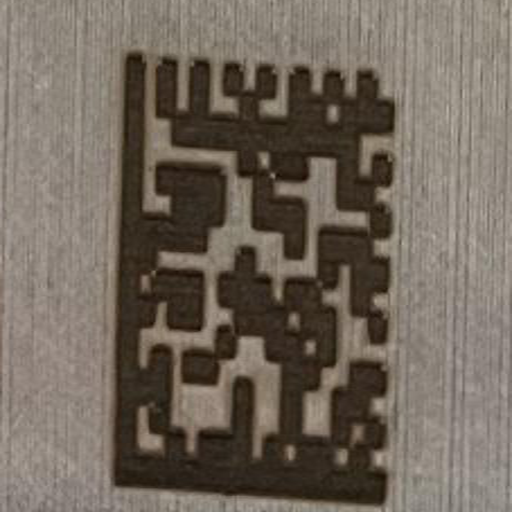

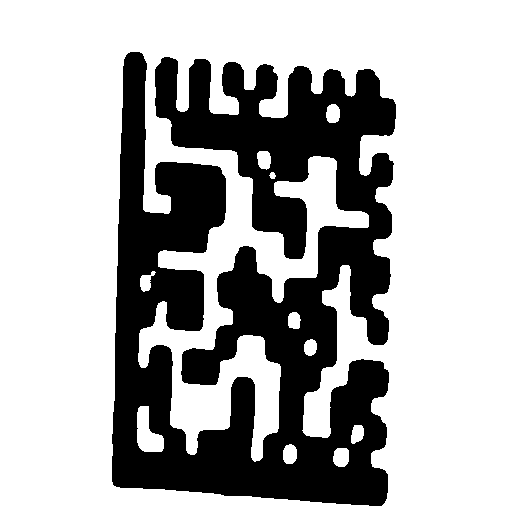

In [4]:
def prepare_image(PIL_img):
    transform = v2.Compose([
        v2.Resize((512, 512), InterpolationMode.BILINEAR),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    img = transform(PIL_img).unsqueeze(0).to(device)

    # img = v2.to_tensor(PIL_img).unsqueeze(0).to(device)
    # img = v2.resize(img, (512, 512), InterpolationMode.BILINEAR)
    return img

# testing
img = Image.open('../../data/MAN/images/test/1G9V68937920005_jpeg.rf.8cf4ab8c3c91d302bcc6d81776399c39.jpg')
yolo_result = yolo(img)
box = yolo_result[0].boxes.xyxy.tolist()[0]

# crop with some padding (to not have too small of a crop)
pad = 45
img_crop = img.crop((max(0, box[0]-pad), max(0, box[1]-pad), max(0, box[2]+pad), max(0, box[3]+pad)))
display(img_crop.resize((512, 512)))

# binarize
img_bin = binarizer_100(prepare_image(img_crop))

# binarize with threshold
img_bin = (img_bin > 0.5).float()

# transform to PIL
img_bin = v2.ToPILImage()(img_bin.squeeze(0).cpu().detach())

# display
display(img_bin)

## Full Evaluation Pipeline

In [5]:
def check_decoding_validity(img_path, decoded_string):

    actual_decoding = os.path.basename(img_path).split('_')[0]
    actual_decoding = actual_decoding.replace('-', '') # minor cleaning

    # fixing some actual decodings
    if actual_decoding == 'KV8INMEP':
        actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
    elif actual_decoding == 'KW8PXY3D':
        actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

    if decoded_string == actual_decoding:
        return True
    else:
        print(f'Invalid decoding! Expected: {actual_decoding}, got: {decoded_string}')
        print(f'Image path: {img_path}')
        return False

In [6]:
def evaluation_pipeline(yolo, binarizer, imgs_path):
    # get all images
    imgs = glob.glob(f'{imgs_path}/*.jpg')

    results = {'img_path': [], 'decoded': [], 'cropped_img': [], 'binarized_img': []}
    valid_decoding_count = 0
    for img_path in imgs:
        img = Image.open(img_path)

        yolo_result = yolo(img, verbose=False)

        try:
            box = yolo_result[0].boxes.xyxy.tolist()[0]
        except:
            results['img_path'].append(img_path)
            results['decoded'].append(None)
            results['cropped_img'].append(None)
            results['binarized_img'].append(None)
            # print progress
            print(f'{len(results["img_path"])} / {len(imgs)}', end='\r')
            continue

        # crop with some padding (to not have too small of a crop)
        pad = 45
        img_crop = img.crop((max(0, box[0]-pad), max(0, box[1]-pad), max(0, box[2]+pad), max(0, box[3]+pad)))

        # binarize with model (gives sigmoid range)
        img_bin = binarizer(prepare_image(img_crop))

        # binarize with threshold (force to 0 or 1)
        img_bin = (img_bin > 0.5).float()

        # transform to PIL for visialization & decoding
        PIL_img = v2.ToPILImage()(img_bin.squeeze(0).cpu().detach())

        # decode
        decoded = decode(PIL_img, timeout=1000, max_count=1)
        if len(decoded) == 0:
            decoded = None
        else:
            decoded = decoded[0].data.decode('utf-8')

        results['img_path'].append(img_path)
        results['decoded'].append(decoded)
        results['cropped_img'].append(img_crop.resize((512, 512)))
        results['binarized_img'].append(PIL_img)

        # check decoding validity (if decoded)
        if decoded and check_decoding_validity(img_path, decoded):
            valid_decoding_count += 1

        # print progress
        print(f'{len(results["img_path"])} / {len(imgs)}', end='\r')

    print(f'Valid decoding count: {valid_decoding_count} / {len(imgs)}')
    return pd.DataFrame(results)

In [63]:
# MESSY FIX FOR ALL MAN DATASET
def evaluation_pipeline_ALL(yolo, binarizer, imgs_path):
    # get all images
    imgs = glob.glob(f'{imgs_path}/*')
    imgs.remove('../../data/extracted\\info.csv')

    results = {'img_path': [], 'decoded': [], 'cropped_img': [], 'binarized_img': []}
    valid_decoding_count = 0
    for img_path in imgs:
        img = Image.open(img_path)

        yolo_result = yolo(img, verbose=False)

        try:
            box = yolo_result[0].boxes.xyxy.tolist()[0]
        except:
            results['img_path'].append(img_path)
            results['decoded'].append(None)
            results['cropped_img'].append(None)
            results['binarized_img'].append(None)
            # print progress
            print(f'{len(results['img_path'])} / {len(imgs)}', end='\r')
            continue

        # crop with some padding (to not have too small of a crop)
        pad = 45
        img_crop = img.crop((max(0, box[0]-pad), max(0, box[1]-pad), max(0, box[2]+pad), max(0, box[3]+pad)))

        # If image is RGBA convert to RGB
        if img_crop.mode == 'RGBA':
            img_crop = img_crop.convert('RGB')

        # binarize with model (gives sigmoid range)
        img_bin = binarizer(prepare_image(img_crop))

        # binarize with threshold (force to 0 or 1)
        img_bin = (img_bin > 0.5).float()

        # transform to PIL for visialization & decoding
        PIL_img = v2.ToPILImage()(img_bin.squeeze(0).cpu().detach())

        # decode
        decoded = decode(PIL_img, timeout=1000, max_count=1)
        if len(decoded) == 0:
            decoded = None
        else:
            decoded = decoded[0].data.decode('utf-8')

        results['img_path'].append(img_path)
        results['decoded'].append(decoded)
        results['cropped_img'].append(img_crop.resize((512, 512)))
        results['binarized_img'].append(PIL_img)

        # AFTER MULTIPLE TESTING - A DMC ONLY DECODES CORRECTLY
        if decoded:
            valid_decoding_count += 1

        # print progress
        print(f'{len(results["img_path"])} / {len(imgs)}', end='\r')

    print(f'Valid decoding count: {valid_decoding_count} / {len(imgs)}')
    return pd.DataFrame(results)

# Running Pipeline - All MAN Data

In [41]:
results_200 = evaluation_pipeline_ALL(yolo, binarizer_100, '../../data/extracted')

Valid decoding count: 31 / 180


# Running Pipeline

In [ ]:
results_100 = evaluation_pipeline(yolo, binarizer_100, '../../data/MAN/images/test')

In [ ]:
results_101 = evaluation_pipeline(yolo, binarizer_101, '../../data/MAN/images/test')

In [ ]:
results_102 = evaluation_pipeline(yolo, binarizer_102, '../../data/MAN/images/test')

# Displaying Decoded Results

In [32]:
def display_results(results):
    results_valid = results[results['decoded'].notnull()]
    for _, row in results_valid.iterrows():
        img_crop = row['cropped_img']
        img_bin = row['binarized_img']
        filepath = row['img_path']
        print(f'Filepath: {filepath}')
        print(f'Decoded: {row["decoded"]}')
        display(img_crop)
        display(img_bin)

In [ ]:
display_results(results_100)

In [ ]:
display_results(results_101)

In [ ]:
display_results(results_102)

In [42]:
results_200['decoded']

0                                  None
1      #D3FPE01YB9NW0047XG505##XF36NATM
2                                  None
3                                  None
4                                  None
                     ...               
175                                None
176                                None
177                                None
178    #D1FPE50HA9NS0047XG264##KV8INMEP
179    #D1FPE50HA9NS0047XG264##KW8PXY3D
Name: decoded, Length: 180, dtype: object

In [64]:
# display_results(results_200)

In [62]:
# count how many successful lazer decodings there were
info = pd.read_csv('../../data/extracted/info.csv', skiprows=1)

lazer_imgs = 0
success_lazer_imgs = 0
for idx, row in results_200.iterrows():
    image_path = row['img_path']
    image_path = image_path.split('\\')[-1].split('.')[0]
    corresponding_row = info[info['serialNo'] == image_path]
    if corresponding_row['marking'].values[0] == 'lazer':
        lazer_imgs += 1
        if row['decoded']:
            success_lazer_imgs += 1
print(f'Successful lazer decodings: {success_lazer_imgs} / {lazer_imgs}')

Successful lazer decodings: 28 / 58


In [67]:
# Decode all images in the extracted folder with baseline decoder
lazer_imgs = 0
success_lazer_imgs = 0
for img_path in glob.glob('../../data/extracted/*'):
    if img_path == '../../data/extracted\\info.csv':
        continue

    img = Image.open(img_path)

    if info[info['serialNo'] == os.path.basename(img_path).split('.')[0]]['marking'].values[0] == 'lazer':
        lazer_imgs += 1
    
        decoded = decode(img, timeout=1000, max_count=1)
        if len(decoded) == 0:
            decoded = None
        else:
            decoded = decoded[0].data.decode('utf-8')
            if decoded:
                success_lazer_imgs += 1
print(f'Successful lazer decodings: {success_lazer_imgs} / {lazer_imgs}')

Successful lazer decodings: 25 / 58


In [50]:
# for idx, row in results_200.iterrows():
#     if row['decoded'] == None:
#         display(row['binarized_img'])